# Animal Species Classification



This Colab notebook provides a streamlined workflow for training a ResNet50 model to classify Animal species.

## Step 1: Libraries

In [1]:
import h5py                     # Hierarchical data format
import cv2                      # Reading and writing images
import numpy as np              # Numpy library
import matplotlib.pyplot as plt # Visualization library
import tensorflow as tf         # Tensorflor library
import os                       # Operating system
import math
import urllib.request
from sklearn.metrics import confusion_matrix


import seaborn as sns;          # Visualization library
sns.set()
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)

In [2]:
# Displays a confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title, ylabel, xlabel):
    fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=1.25)
    plt.show()

In [3]:
# This function displays images and their corresponding ground truth and
# predicted labels.
def display_predictions( images, labels, classnames, predicted_classes, max_display_images, border=1):

  # set the number of images to display
  numbers_to_display = min(labels.shape[0], max_display_images)

  # select random indices.
  indices = np.random.choice(len(images), size=numbers_to_display, replace=False)

  num_cells = math.ceil(math.sqrt(numbers_to_display))
  plt.figure(figsize=(10, 10))

  for plot_index in range(numbers_to_display):

      # select an index
      item_index = indices[ plot_index ]

      # retrieve the label at the selected index
      predicted_label = predicted_classes[item_index]

      # retrieve the image at the selected index
      img = images[item_index,:,:,:]

      # create a subplot tao draw the image
      ax = plt.subplot(num_cells, num_cells, plot_index + 1)

      # disable ticks and grid
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)

      # determine border color
      color = 'white'
      if predicted_label == labels[item_index]:
        color = 'green'
      else:
        color = 'red'

      # set border width
      ax.spines['bottom'].set_linewidth(border)
      ax.spines['top'].set_linewidth(border)
      ax.spines['right'].set_linewidth(border)
      ax.spines['left'].set_linewidth(border)

      # set border color
      ax.spines['bottom'].set_color(color)
      ax.spines['top'].set_color(color)
      ax.spines['right'].set_color(color)
      ax.spines['left'].set_color(color)

      # display the image
      plt.imshow(img)

      # display the corresponding label
      plt.xlabel(classnames[ predicted_label ])

  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  plt.show()

## Step 2: Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Replace the following variable with the exact path where you want to save the model.
path_experiment_folder = '/content/drive/MyDrive/2025/AI Day/Projects/4thYear/AnimalSpeciesDetection/Experiment'

# Path to your model
path_model = os.path.join(path_experiment_folder, 'Model', 'resnet.keras')

# Path to your data
path_data = os.path.join(path_experiment_folder, 'Data', 'data.h5')

## Step 3: Data

In [7]:
# Load the gesture data
train_images = []
train_labels = []
test_images = []
test_labels = []
valid_images = []
valid_labels = []

path_data = os.path.join( path_data )
with h5py.File(path_data, "r") as f:
  train_images = f['Training-images'][:]
  train_labels = f['Training-labels'][:]
  valid_images = f['Validation-images'][:]
  valid_labels = f['Validation-labels'][:]
  classnames = f['classnames'][:]

classnames = [b.decode('utf-8') for b in classnames]


In [8]:
# Normalize the data
train_images = train_images/255.0
valid_images = valid_images/255.0

In [9]:
# confirm the sizes of the data
print('Train set images: ', train_images.shape, 'labels: ', train_labels.shape )
print('Validation set images: ', valid_images.shape, 'labels: ', valid_labels.shape )
print('Classes:', classnames)

Train set images:  (400, 128, 128, 3) labels:  (400,)
Validation set images:  (800, 128, 128, 3) labels:  (800,)
Classes: ['Cow', 'Dog', 'Elephant', 'Tiger']


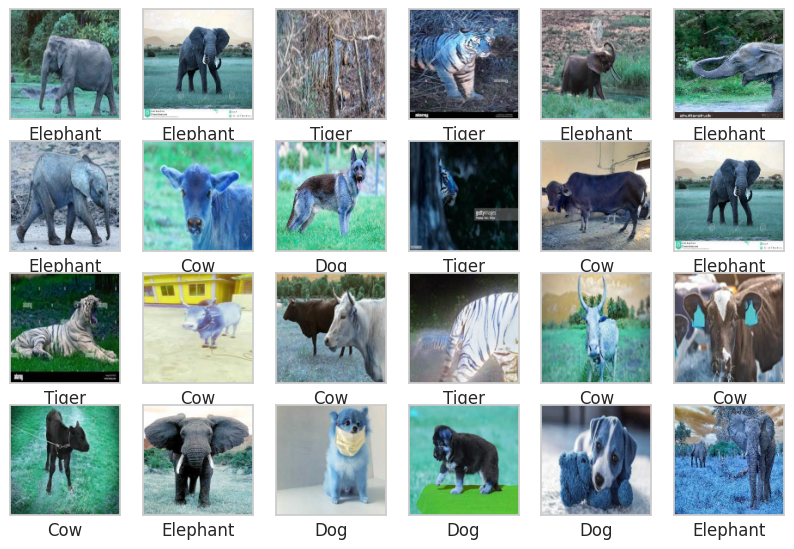

In [10]:
# visualize training examples

# The number of images to visualize
num_images_to_display = 24

# Select random indices from the image array
indices = np.random.choice(train_images.shape[0], num_images_to_display)

# Visualize the images
plt.figure(figsize=(10,10))
for i in range(num_images_to_display):
    index = indices[i]
    label = train_labels[index]
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[index])
    plt.xlabel( classnames[label] )
plt.show()

# Step 4: ResNet50

### Model

In [12]:
# This function creates a ResNet model for fine-tuning
def create_resnet(input_shape):

  # Pre - Trained Model
  base_model = tf.keras.applications.ResNet50V2(include_top=False, input_shape=input_shape, weights='imagenet')

  # Freeze Weights
  base_model.trainable = False

  # Model Architecture
  model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(len(classnames), activation='softmax')
  ])

  return model

### Fine-Tuning

In [ ]:
# Create the model
model = create_resnet( input_shape = train_images.shape[1:] )

# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

# Callbacks
cbs = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
      tf.keras.callbacks.ModelCheckpoint(path_model, save_best_only=True)]


# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
history = model.fit(train_images,             # training features
                    train_labels,             # training labels
                    epochs=20,           # number of iterations to train the model
                    batch_size=32,       # batch size for gradient descent
                    verbose=2,           # level ouf output to proint
                    callbacks=cbs,
                    validation_data=(valid_images, valid_labels)) # test features and labels

In [ ]:
# Visualize the training and test loss
# The graph of the loss should show the loss of the
# network decreasing as the training progresses.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Sparse Categorical Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# Visualize the training and test accuracy
# The graph of the accuracy should show the accuracy of the
# network increasing as the training progresses.
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

### Evaluation

In [ ]:
loaded_model = tf.keras.models.load_model( path_model )

In [ ]:
# Evaluate the model on the entire test dataset
# to determine its accuracy on unseen data
test_loss, test_acc = loaded_model.evaluate(test_images, test_labels)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9054 - loss: 0.3857
Test accuracy: 89.87%


In [ ]:
# Make predictions on the test dataset
predictions = loaded_model.predict(test_images)

# Convert the probability map to class labels
pred_classes = np.argmax(predictions,axis=1)

# Display the confusion matrix
plot_heatmap(test_labels, pred_classes, classnames, title="ResNet Confusion Matrix", ylabel='Label', xlabel='Prediction')

In [ ]:
# Display predictions from our model.
# Correct predictions are rendered with green border, and incorrect
# predictions are rendered with red border.
display_predictions(test_images, test_labels, classnames, pred_classes, 42, border=2)

In [ ]:
# Predict on unseen image
path_image = '/content/drive/MyDrive/2025/AI Day/Projects/4thYear/AnimalSpeciesDetection/Experiment/Data/Testing/Cow/Cow-Test (103).jpeg'


imagesize = 128
image = cv2.imread( path_image )
image = cv2.resize(image, (imagesize, imagesize))
image_array = np.expand_dims(image, axis=0)/255.0
prediction = loaded_model.predict(image_array)

# Convert the probability map to class labels
predicted_class = np.argmax(prediction,axis=1)[0]

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xlabel( classnames[predicted_class] )
plt.show()
